# NLP and Metadata

By Alberto Valdés

**Mail 1:** anvaldes@uc.cl

**Mail 2:** alberto.valdes.gonzalez.96@gmail.com

This notebook was devoloped in Google Colab using "T4 GPU".

We going to use the large of the text as metadata.

### Input Data

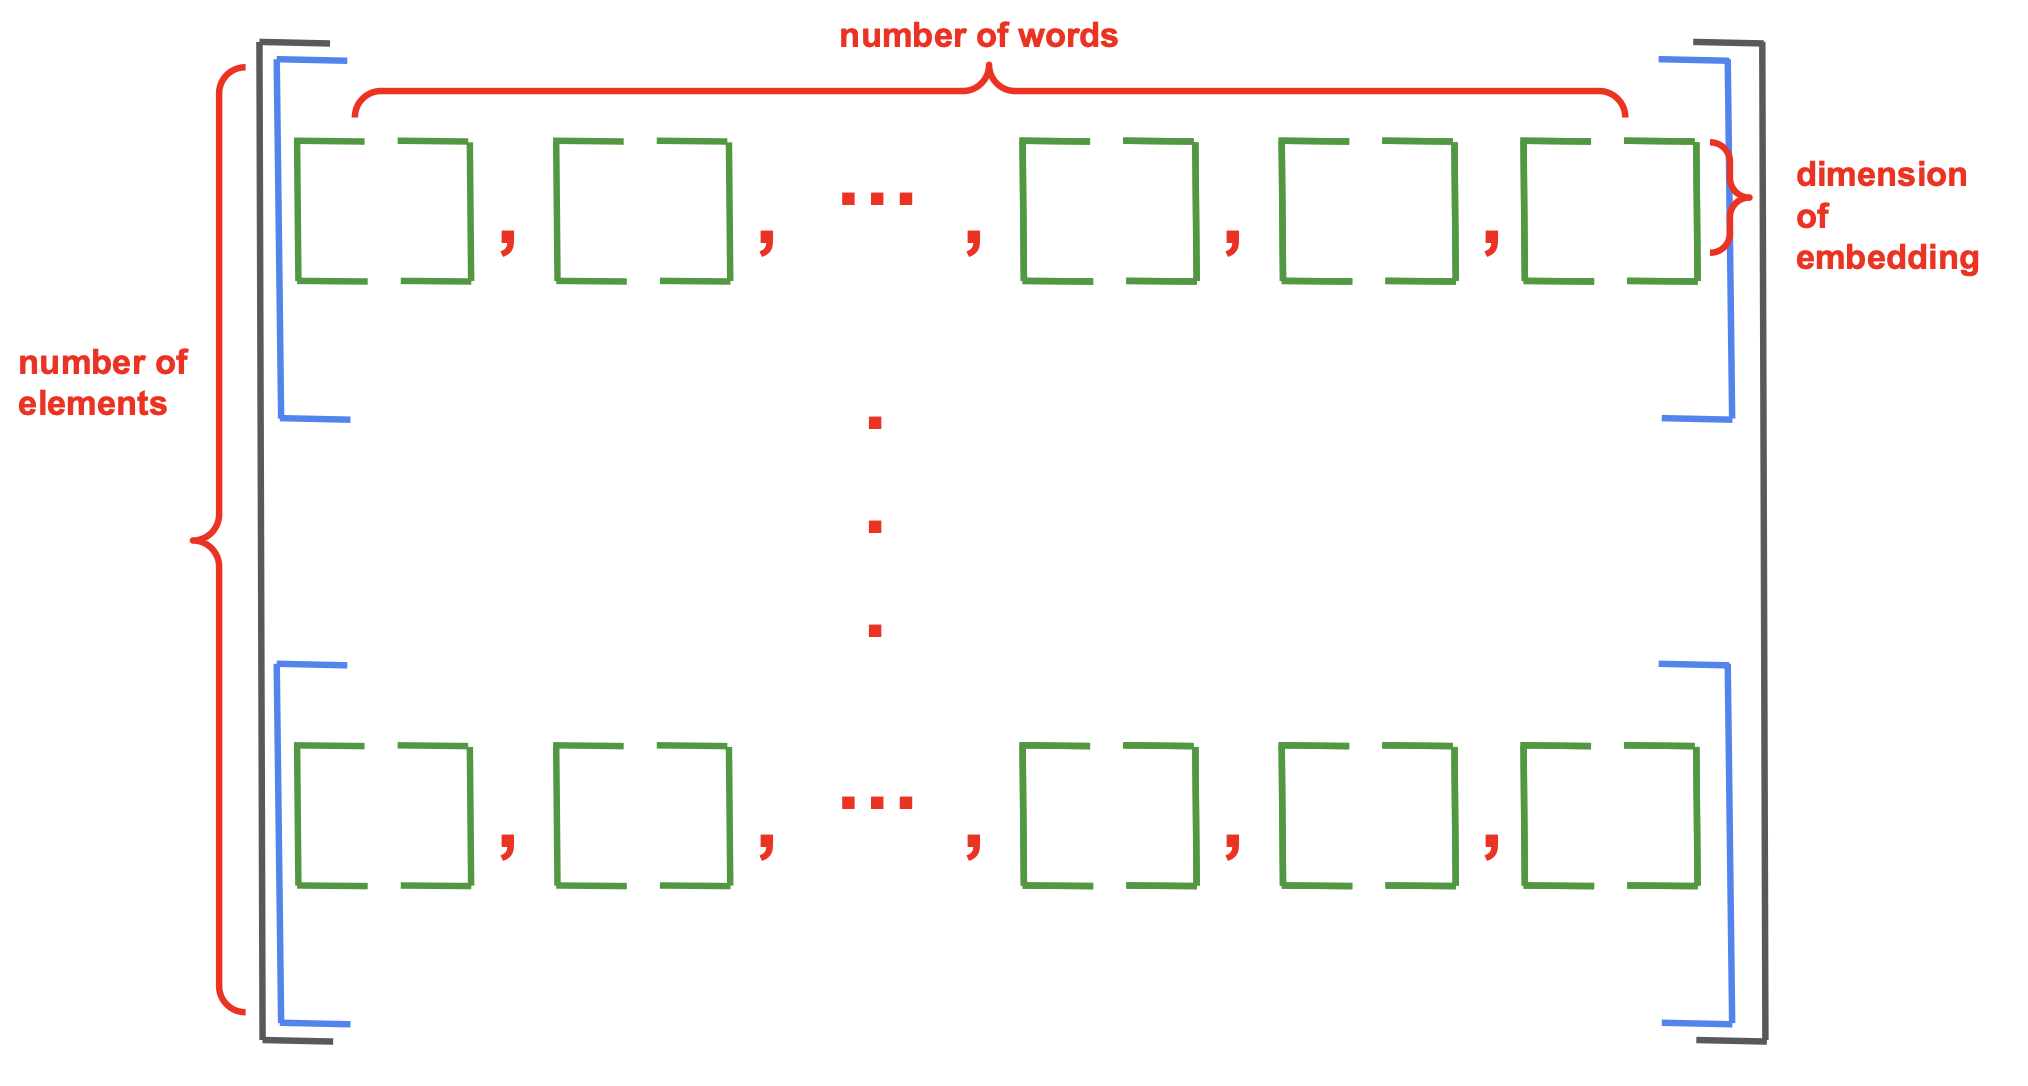

**Data Type at Entry:** Torch tensors.

**Data Type at Output:** Torch tensors.

In [1]:
import time
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
def print_time_execution(start, end, txt):

  delta = int(end - start)

  hours = int(delta/3_600)
  mins = int((delta - 3_600*hours)/60)
  segs = int(delta - hours*3600 - mins*60)

  return f'{txt} it takes {hours} hours, {mins} mins and {segs} segs.'

### Start time of execution

In [3]:
start = time.time()

# Functions

In [4]:
def clean_text(text):

  new_text = ''

  for t in text:

    ind_1 = t.isdigit()
    ind_2 = t.isalpha()
    ind_3 = (t == ' ')

    if ind_1 or ind_2 or ind_3:

      new_text = new_text + t

  return new_text

# 1. Load datasets

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
path = 'drive/MyDrive/Profesional_Academico/Github_Personal/ML_AI_Contents/09.Deep_Learning/67.NLP_MetaData_Keras_TF'

In [7]:
df = pd.read_csv(f'{path}/spam.csv', encoding='ISO-8859-1')

In [8]:
df = df[['v1', 'v2']]
df = df.rename(columns = {'v1': 'label', 'v2': 'text'})

In [9]:
df['label'] = (df['label'] == 'spam')*1

In [10]:
df['text'] = df['text'].map(lambda x: clean_text(x))
df['text'] = df['text'].map(lambda x: x.lower())

In [11]:
df['len_text'] = df['text'].map(lambda x: len(x))
df['len_words'] = df['text'].map(lambda x: len(x.split(' ')))

In [12]:
round(((df['len_text'] <= 300).sum()/len(df))*100, 2)

99.46

In [13]:
round(((df['len_words'] <= 60).sum()/len(df))*100, 2)

99.28

In [14]:
df.shape

(5572, 4)

In [15]:
df = df[(df['len_words'] <= 60) & (df['len_text'] <= 300)]

In [16]:
df.shape

(5532, 4)

In [17]:
X = df[['text', 'len_text']].copy()
y = df['label'].copy()

# 2. Split

In [18]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.4, random_state = 42)

In [19]:
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size = 0.5, random_state = 42)

# 3. Tokenization

In [20]:
import warnings
warnings.filterwarnings("ignore")

In [21]:
def txt_to_vec(text, max_len, embedding):

  vec_txt = []

  split_text = text.split(' ')

  for i in range(max_len):

    try:
      s_t = split_text[i]
      vec_txt.append(embedding[s_t])

    except:
      vec_txt.append(np.zeros(300))

  return vec_txt

In [22]:
from sklearn.metrics import f1_score, recall_score, precision_score

In [23]:
import gensim.downloader

In [24]:
%%time

glove_vectors = gensim.downloader.load('word2vec-google-news-300')

CPU times: user 46.2 s, sys: 2.91 s, total: 49.1 s
Wall time: 49.2 s


In [25]:
max_len = 60
n_batches_train = 4

In [26]:
def word_2_vec(input_X, input_y, embedding, n_batches, max_len):

  output_X_text = []
  output_X_len = []
  output_y = []

  h_batches = int(len(input_X)/n_batches) + 1

  for n_batch in range(n_batches):

    input_X_batch = input_X.iloc[n_batch*h_batches: (n_batch + 1)*h_batches]
    input_y_batch = input_y.iloc[n_batch*h_batches: (n_batch + 1)*h_batches]

    out_X_text = []
    out_X_len = []
    out_y = []

    for i in range(len(input_X_batch)):

      text_part = input_X_batch['text'].iloc[i]
      class_part = input_y_batch.iloc[i]

      out_X_text.append(txt_to_vec(text_part, max_len, embedding))
      out_X_len.append(input_X_batch['len_text'].iloc[i])

      if class_part == 1:

        out_y.append([1, 0])

      else:

        out_y.append([0, 1])

    output_X_text.append(torch.Tensor(out_X_text))
    output_X_len.append(torch.Tensor(out_X_len))

    output_y.append(torch.Tensor(out_y))

  return output_X_text, output_X_len, output_y

In [27]:
X_train_text_c, X_train_len_c, y_train_c = word_2_vec(X_train, y_train, glove_vectors, n_batches_train, max_len)

In [28]:
X_val_text_c, X_val_len_c, y_val_c = word_2_vec(X_val, y_val, glove_vectors, 1, max_len)

In [29]:
X_test_text_c, X_test_len_c, y_test_c = word_2_vec(X_test, y_test, glove_vectors, 1, max_len)

# 2. Creation class NN

In [30]:
class LSTM(nn.Module):

    def __init__(self, input_size, output_size, hidden_dim, n_layers, len_words, device):
        super(LSTM, self).__init__()

        self.input_size = input_size
        self.output_size = output_size
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        self.len_words = len_words

        self.lstm = nn.LSTM(input_size, hidden_dim, n_layers, batch_first=True)

        self.flatten = nn.Flatten()

        self.fc = nn.Linear(self.hidden_dim*self.len_words, output_size)

        self.logsoftmax = nn.LogSoftmax(dim=1)

        self.device = device

    def forward(self, x):

        batch_size = len(x)

        h = self.init_hidden(batch_size)
        c = self.init_hidden(batch_size)

        out, (h, c) = self.lstm(x, (h,c))

        out = self.flatten(out)

        out = self.fc(out)

        out = self.logsoftmax(out)

        return out

    def init_hidden(self, batch_size):
        h = torch.zeros(self.n_layers, batch_size, self.hidden_dim)
        return h.to(self.device)

# 3. Send sets to device

In [31]:
# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


In [32]:
for i in range(n_batches_train):

  # Train

  X_train_text_c[i] = X_train_text_c[i].to(device)
  X_train_len_c[i] = X_train_len_c[i].to(device)
  y_train_c[i] = y_train_c[i].to(device)

# Validation

X_val_text_c[0] = X_val_text_c[0].to(device)
X_val_len_c[0] = X_val_len_c[0].to(device)
y_val_c[0] = y_val_c[0].to(device)

# Test

X_test_text_c[0] = X_test_text_c[0].to(device)
X_test_len_c[0] = X_test_len_c[0].to(device)
y_test_c[0] = y_test_c[0].to(device)

# 4. Model to device

In [33]:
hidden_dim = 80
n_layers = 2
lr = 0.001
n_epochs = 20
input_size = 300
output_size = 2
len_words = max_len

In [34]:
model = LSTM(input_size, output_size, hidden_dim, n_layers, len_words, device)

In [35]:
model.to(device)

LSTM(
  (lstm): LSTM(300, 80, num_layers=2, batch_first=True)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc): Linear(in_features=4800, out_features=2, bias=True)
  (logsoftmax): LogSoftmax(dim=1)
)

# 5. Train

In [36]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = lr)

In [37]:
all_loss_train = []
all_loss_val = []

all_recall_train = []
all_recall_val = []

all_epochs = []

In [38]:
for epoch in range(1, n_epochs + 1):

  # 1. Train

  loss_train_epoch = 0
  recall_train_epoch = 0

  model.train()

  for n in range(n_batches_train):

    X_batch_text = X_train_text_c[n]
    y_batch = y_train_c[n]

    optimizer.zero_grad()

    out_train_batch = model(X_batch_text)
    loss_train_batch = criterion(out_train_batch, y_batch)

    loss_train_batch.backward()
    optimizer.step()

    loss_train_epoch = loss_train_epoch + loss_train_batch.item()/len(X_batch_text)

    recall_train_batch = recall_score(
            y_batch[:, 0].cpu().detach().numpy(),
            (np.exp(out_train_batch.cpu().detach().numpy())[:, 0] > 0.134)*1,
            average = 'macro'
            )

    recall_train_epoch = recall_train_epoch + recall_train_batch

  loss_train_epoch = loss_train_epoch/n_batches_train
  all_loss_train.append(loss_train_epoch)
  all_epochs.append(epoch)

  recall_train_epoch = recall_train_epoch/n_batches_train
  recall_train_epoch = round(recall_train_epoch*100, 2)

  all_recall_train.append(recall_train_epoch)

  # 2. Evaluation

  model.eval()

  out_val = model(X_val_text_c[0])
  loss_val = criterion(out_val, y_val_c[0])
  loss_val = loss_val.item()/len(X_val_text_c[0])

  all_loss_val.append(loss_val)

  recall_val = recall_score(
          y_val_c[0][:, 0].cpu().detach().numpy(),
          (np.exp(out_val.cpu().detach().numpy())[:, 0] > 0.134)*1,
          average = 'macro'
      )

  recall_val = round(recall_val*100, 2)
  all_recall_val.append(recall_val)

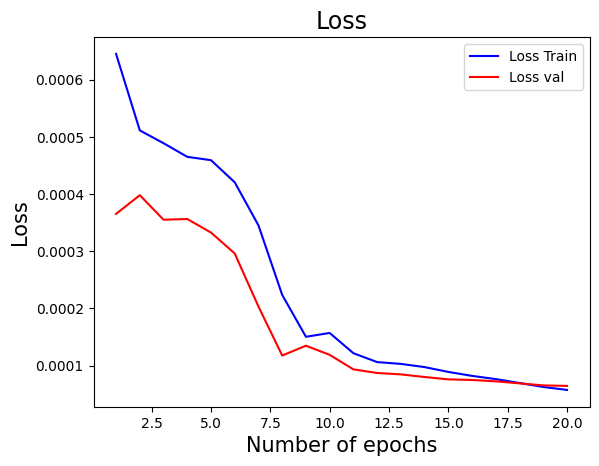

In [39]:
plt.plot(all_epochs, all_loss_train, label = 'Loss Train', color = 'blue')
plt.plot(all_epochs, all_loss_val, label = 'Loss val', color = 'red')

plt.title('Loss', fontsize = 17)

plt.xlabel('Number of epochs', fontsize = 15)
plt.ylabel('Loss', fontsize = 15)

plt.legend()

plt.show()

# 6. Last Layer

In [40]:
model_lstm = model.lstm

In [41]:
batch_size_val = len(X_val_text_c[0])

h_val = model.init_hidden(batch_size_val)
c_val = model.init_hidden(batch_size_val)

out_val, (h_val, c_val) = model_lstm(X_val_text_c[0], (h_val, c_val))
out_val = model.flatten(out_val)

In [42]:
batch_size_test = len(X_test_text_c[0])

h_test = model.init_hidden(batch_size_test)
c_test = model.init_hidden(batch_size_test)

out_test, (h_test, c_test) = model_lstm(X_test_text_c[0], (h_test, c_test))
out_test = model.flatten(out_test)

In [43]:
df_val = pd.DataFrame(out_val.detach().to('cpu'))
df_val['len'] = X_val_len_c[0].detach().to('cpu')

In [44]:
df_test = pd.DataFrame(out_test.detach().to('cpu'))
df_test['len'] = X_test_len_c[0].detach().to('cpu')

# 7. ML

In [45]:
threshold = round(y_val.mean(), 2)

In [46]:
from xgboost import XGBClassifier

In [47]:
N_est_max = 100
M_depth_max = 10

N_est = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
M_depth = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [48]:
all_f1_val = []
all_f1_test = []
all_params = []

for n_est in N_est:

    print('N estimators: ', n_est)

    for m_depth in M_depth:

        clf = XGBClassifier(n_estimators = n_est, max_depth = m_depth, learning_rate = 0.2, random_state = 0)

        clf = clf.fit(df_val, y_val)

        y_val_pred_prob = clf.predict_proba(df_val)[:, 1]
        y_test_pred_prob = clf.predict_proba(df_test)[:, 1]

        y_val_pred = (y_val_pred_prob >= threshold)*1
        y_test_pred = (y_test_pred_prob >= threshold)*1

        f1_val = f1_score(y_val, y_val_pred)
        f1_test = f1_score(y_test, y_test_pred)

        all_f1_val.append(f1_val)
        all_f1_test.append(f1_test)
        all_params.append([n_est, m_depth])

    print('-'*70)

all_f1_train = np.array(all_f1_val)
all_f1_val = np.array(all_f1_test)
all_params = np.array(all_params)

N estimators:  10
----------------------------------------------------------------------
N estimators:  20
----------------------------------------------------------------------
N estimators:  30
----------------------------------------------------------------------
N estimators:  40
----------------------------------------------------------------------
N estimators:  50
----------------------------------------------------------------------
N estimators:  60
----------------------------------------------------------------------
N estimators:  70
----------------------------------------------------------------------
N estimators:  80
----------------------------------------------------------------------
N estimators:  90
----------------------------------------------------------------------
N estimators:  100
----------------------------------------------------------------------


In [49]:
all_f1_val = np.array(all_f1_val)
all_f1_test = np.array(all_f1_test)
all_params = np.array(all_params)

In [50]:
f1_val_opt = all_f1_val[all_f1_test == all_f1_test.max()][0]
f1_test_opt = all_f1_test[all_f1_test == all_f1_test.max()][0]
N_est_opt, M_depth_opt = all_params[all_f1_test == all_f1_test.max()][0]

# 8. Definitive model

In [51]:
N_est_opt, M_depth_opt

(100, 3)

In [52]:
clf = XGBClassifier(n_estimators = N_est_opt, max_depth = M_depth_opt, learning_rate = 0.2, random_state = 0)

In [53]:
clf = clf.fit(df_val, y_val)

In [54]:
fi = pd.DataFrame(zip(clf.feature_names_in_, clf.feature_importances_))

In [55]:
fi = fi.rename(columns = {0: 'variables', 1: 'importance'})

In [56]:
fi = fi.sort_values(by = ['importance'], ascending = False)

In [57]:
fi = fi[fi['importance'] > 0]

In [58]:
names_var = list(fi['variables'])
names_var = [int(i) for i in names_var if i != 'len']

In [59]:
df_val = df_val[names_var]
df_test = df_test[names_var]

In [60]:
clf = XGBClassifier(n_estimators = N_est_opt, max_depth = M_depth_opt, learning_rate = 0.2, random_state = 0)

In [61]:
clf = clf.fit(df_val, y_val)

In [62]:
y_val_pred = (clf.predict_proba(df_val)[:, 1] > threshold)*1
y_test_pred = (clf.predict_proba(df_test)[:, 1] > threshold)*1

# 9. Performance

### a. Validation

In [63]:
round(precision_score(y_val, y_val_pred, average = 'macro')*100, 2)

100.0

In [64]:
round(recall_score(y_val, y_val_pred, average = 'macro')*100, 2)

100.0

In [65]:
round(f1_score(y_val, y_val_pred, average = 'macro')*100, 2)

100.0

### b. Test

In [66]:
round(precision_score(y_test, y_test_pred, average = 'macro')*100, 2)

91.81

In [67]:
round(recall_score(y_test, y_test_pred, average = 'macro')*100, 2)

94.55

In [68]:
round(f1_score(y_test, y_test_pred, average = 'macro')*100, 2)

93.12

### End time of execution

In [69]:
end = time.time()

In [70]:
print(print_time_execution(start, end, 'notebook execution'))

notebook execution it takes 0 hours, 12 mins and 19 segs.
